## Image Recognition using AlexNet Architechture on CIFAR-10 Dataset

## Introduction
AlexNet was designed by Hinton, winner of the 2012 ImageNet competition, and his student Alex Krizhevsky. It was also after that year that more and deeper neural networks were proposed, such as the excellent vgg, GoogleLeNet. Its official data model has an accuracy rate of 57.1% and top 1-5 reaches 80.2%. This is already quite outstanding for traditional machine learning classification algorithms.

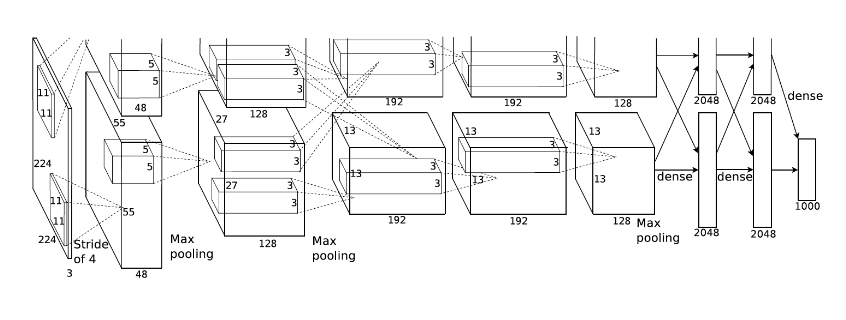

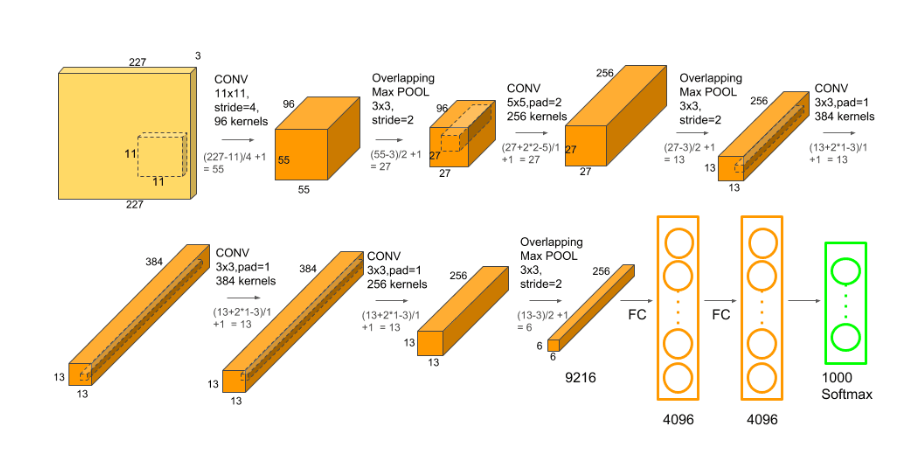

# The following table below explains the network structure of AlexNet:

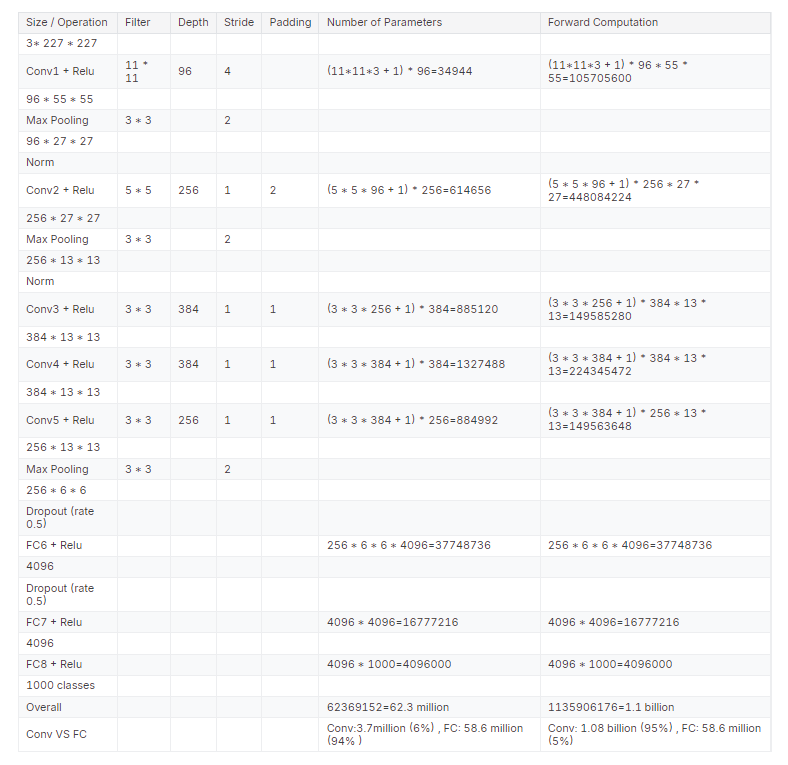

# Why does AlexNet achieve better results?
Relu activation function is used:
Relu function: f (x) = max (0, x)

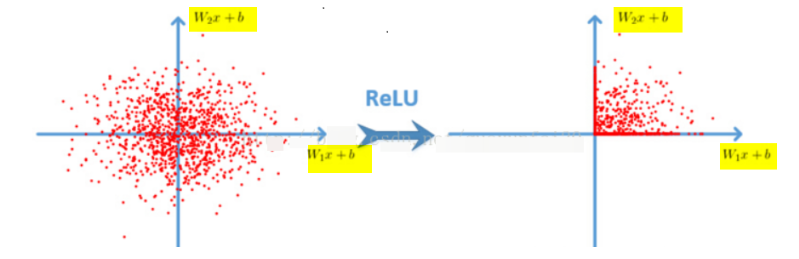

ReLU-based deep convolutional networks are trained several times faster than tanh and sigmoid- based networks. The following figure shows the number of iterations for a four-layer convolutional network based on CIFAR-10 that reached 25% training error in tanh and ReLU:

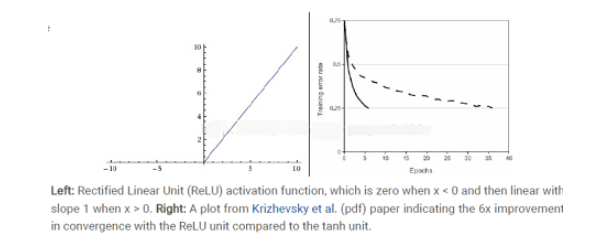

# Standardization (Local Response Normalization)

After using ReLU f (x) = max (0, x), you will find that the value after the activation function has no range like the tanh and sigmoid functions, so a normalization will usually be done after ReLU, and the LRU is a steady proposal (Not sure here, it should be proposed?) One method in neuroscience is called "Lateral inhibition", which talks about the effect of active neurons on its surrounding neurons.

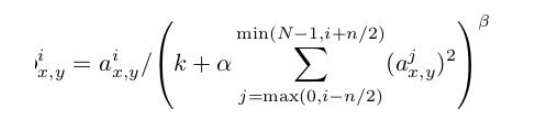

# Dropout

Dropout is also a concept often said, which can effectively prevent overfitting of neural networks. Compared to the general linear model, a regular method is used to prevent the model from overfitting. In the neural network, Dropout is implemented by modifying the structure of the neural network itself. For a certain layer of neurons, randomly delete some neurons with a defined probability, while keeping the individuals of the input layer and output layer neurons unchanged, and then update the parameters according to the learning method of the neural network. In the next iteration, rerandom Remove some neurons until the end of training.

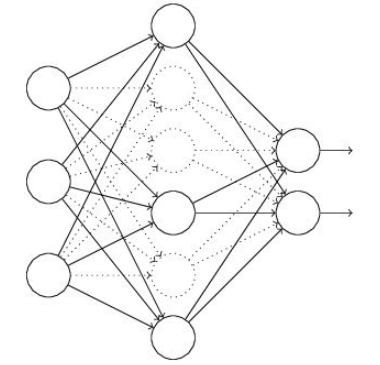

# Enhanced Data (Data Augmentation)

In deep learning, when the amount of data is not large enough, there are generally 4 solutions:

1. Data augmentation- artificially increase the size of the training set-create a batch of "new" data from existing data by means of translation, flipping, noise

2. Regularization——The relatively small amount of data will cause the model to overfit, making the training error small and the test error particularly large. By adding a regular term after the Loss Function , the overfitting can be suppressed. The disadvantage is that a need is introduced Manually adjusted hyper-parameter.

3. Dropout- also a regularization method. But different from the above, it is achieved by randomly setting the output of some neurons to zero

4. Unsupervised Pre-training- use Auto-Encoder or RBM's convolution form to do unsupervised pre-training layer by layer, and finally add a classification layer to do supervised Fine-Tuning

# Code Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

c:\Users\keyur\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT,  train = True, download = True)

Files already downloaded and verified


In [4]:
# Compute means and standard deviations along the R, G, B channels
means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Means: {means}')
print(f'Standard Deviations: {stds}')

Means: [0.49139968 0.48215841 0.44653091]
Standard Deviations: [0.24703223 0.24348513 0.26158784]


In [5]:
# Defining data augmentation techniques for training data
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

# Defining transformations for test/validation data (only normalization)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])


In [6]:
# Applying the transformations to the CIFAR-10 dataset
train_data = datasets.CIFAR10(ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(ROOT, train=False, download=True, transform=test_transforms)

# Splitting the training data into training and validation sets
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f'Training samples: {len(train_data)}')
print(f'Validation samples: {len(valid_data)}')
print(f'Test samples: {len(test_data)}')


Files already downloaded and verified
Files already downloaded and verified
Training samples: 45000
Validation samples: 5000
Test samples: 10000


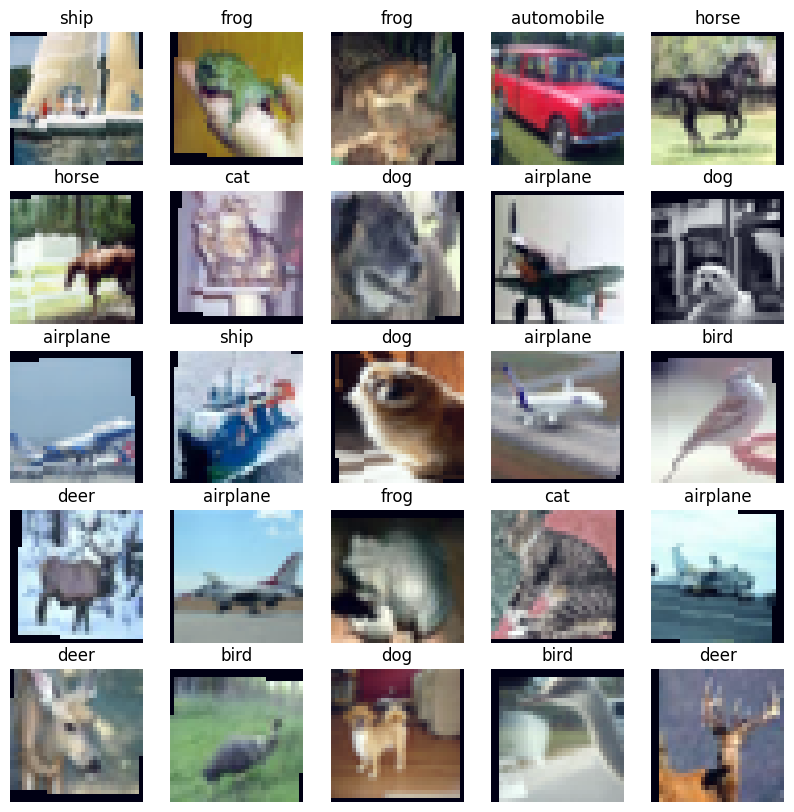

In [7]:
# Function to plot images and their corresponding labels
def plot_images(images, labels, classes, normalize=False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

# Selecting a few images to visualize from the training data
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes

# Plotting the selected images
plot_images(images, labels, classes, normalize=True)


In [8]:
# Creating data loaders for train, validation, and test sets with batch size 256
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)


In [9]:
# Defining the AlexNet model architecture
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

# Initializing the model with the appropriate output dimension
OUTPUT_DIM = 10
model = AlexNet(OUTPUT_DIM)


In [10]:
# Function to initialize model parameters using Kaiming and Xavier initialization
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

# Applying the parameter initialization function to the model
model.apply(initialize_parameters)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [11]:
# Defining optimizer, device, and loss function (criterion)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

# Moving the model and criterion to the GPU (if available)
model = model.to(device)
criterion = criterion.to(device)


In [12]:
# Function to calculate accuracy based on model predictions
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training function for a single epoch
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function for validation and test sets
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [13]:
# Function to calculate elapsed time in minutes and seconds
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Training the model for a specified number of epochs
EPOCHS = 100
best_valid_loss = float('inf')  # Initialize best validation loss as infinity

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 2.405 | Train Acc: 22.61%
	Valid Loss: 1.599 | Valid Acc: 39.54%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 1.531 | Train Acc: 43.03%
	Valid Loss: 1.414 | Valid Acc: 48.51%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.354 | Train Acc: 50.81%
	Valid Loss: 1.278 | Valid Acc: 53.41%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.252 | Train Acc: 55.07%
	Valid Loss: 1.196 | Valid Acc: 57.09%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.176 | Train Acc: 57.92%
	Valid Loss: 1.124 | Valid Acc: 60.39%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.106 | Train Acc: 60.64%
	Valid Loss: 1.088 | Valid Acc: 61.73%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.067 | Train Acc: 62.37%
	Valid Loss: 1.051 | Valid Acc: 63.22%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.013 | Train Acc: 64.45%
	Valid Loss: 1.015 | Valid Acc: 64.27%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.974 | Train Acc: 65.73%
	Valid Loss: 0.951 | Valid Acc: 66.15%
Epoch: 10 | Epoch T

In [14]:
# Loading the best model after training
model.load_state_dict(torch.load('best-model.pt'))

# Evaluating the model on the test set
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


C:\Users\keyur\AppData\Local\Temp\ipykernel_27264\808407178.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.pt'))


Test Loss: 0.673 | Test Acc: 79.38%


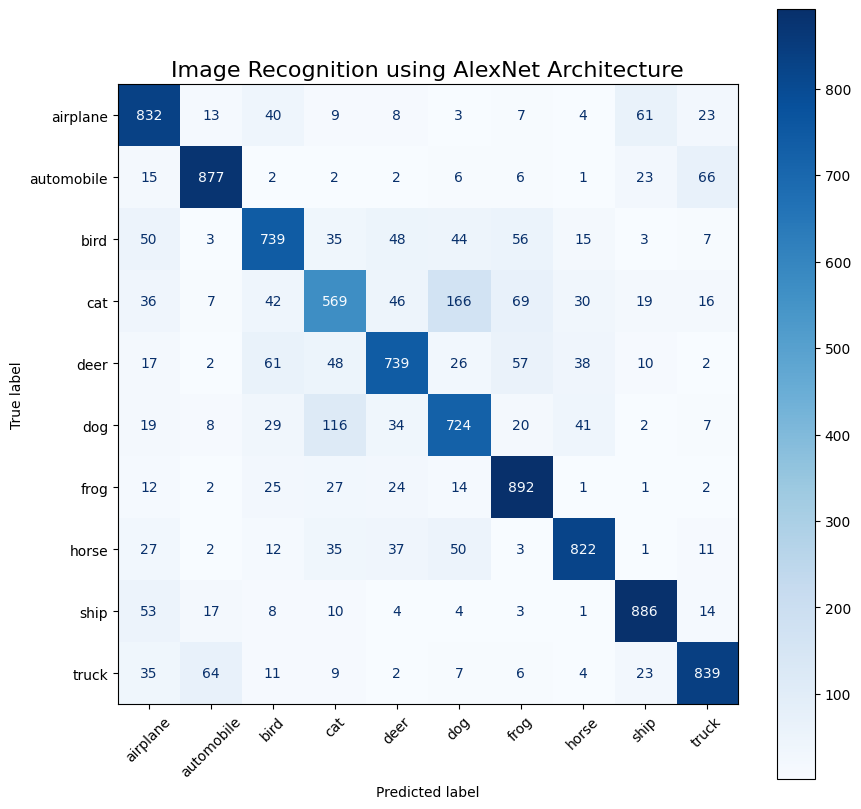

In [15]:
# Function to get predictions from the model
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    
    return torch.cat(images, dim=0), torch.cat(labels, dim=0), torch.cat(probs, dim=0)

# Getting predictions from the model
images, labels, probs = get_predictions(model, test_iterator, device)

# Getting the top predictions
pred_labels = torch.argmax(probs, 1)

# Creating a confusion matrix based on the predictions
conf_mat = confusion_matrix(labels, pred_labels)

# Displaying the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot(values_format='d', cmap='Blues', ax=ax)
ax.set_title('Image Recognition using AlexNet Architecture', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [16]:
# Function to normalize an image for visualization purposes
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


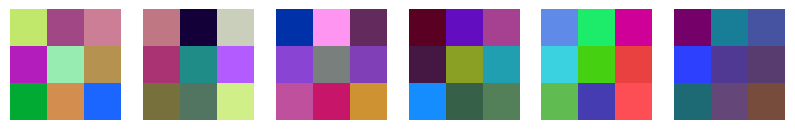

In [17]:
# Function to visualize the filters learned by the first convolutional layer
def plot_filters(layer, n_filters=6):
    filters = layer.weight.data.clone()
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i + 1)
        ax.imshow(normalize_image(filters[i]).permute(1, 2, 0).cpu().numpy())
        ax.axis('off')

# Visualizing the first convolutional layer filters
plot_filters(model.features[0], n_filters=6)


In [18]:
# Save the trained model to a specified directory
MODEL_PATH = r'D:\CODE\projects\AlexNet Neural Networks\cifar10_alexnet_model.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f'Model saved to {MODEL_PATH}')


Model saved to D:\CODE\projects\AlexNet Neural Networks\cifar10_alexnet_model.pth


C:\Users\keyur\AppData\Local\Temp\ipykernel_27264\1012605395.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))
Clipping input

Model loaded from D:\CODE\projects\AlexNet Neural Networks\cifar10_alexnet_model.pth


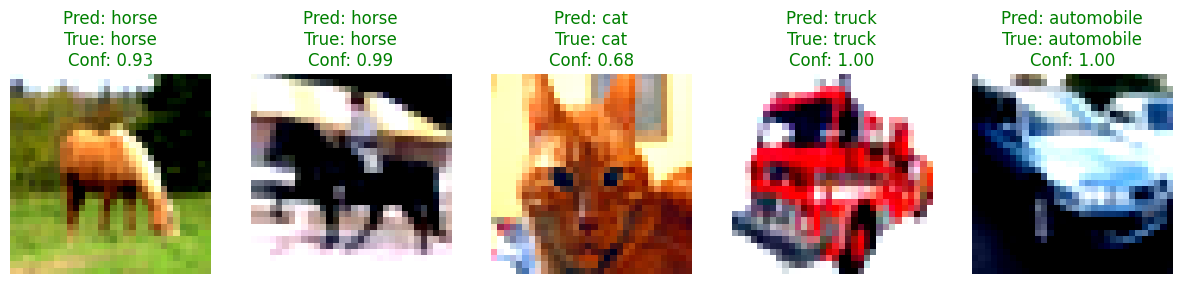

In [24]:
# Load the model from the specified file
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(f'Model loaded from {MODEL_PATH}')

# Function to unnormalize images for display
def unnormalize_image(img):
    img = img / 2 + 0.5  # Undo normalization
    return img

# Function to visualize images with their predicted and actual labels, and prediction confidence
def visualize_predictions_with_confidence(images, labels, pred_labels, confidences, classes):
    fig = plt.figure(figsize=(15, 6))
    
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i + 1)
        img = unnormalize_image(images[i])  # Unnormalize the image
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f'Pred: {classes[pred_labels[i]]}\nTrue: {classes[labels[i]]}\nConf: {confidences[i]:.2f}', 
                     color=("green" if pred_labels[i] == labels[i] else "red"))
        ax.axis('off')

# Select a configurable number of random images from the test set
n_images = 5  # <-- Change this number to predict a different number of images
test_images, test_labels = zip(*[(image, label) for image, label in [test_data[i] for i in random.sample(range(len(test_data)), n_images)]])

# Convert selected images to tensors and move them to the appropriate device
test_images_tensor = torch.stack(test_images).to(device)

# Make predictions on the selected images
with torch.no_grad():
    y_pred, _ = model(test_images_tensor)
    y_prob = F.softmax(y_pred, dim=-1)
    pred_labels = torch.argmax(y_prob, 1).cpu()
    confidences = torch.max(y_prob, 1).values.cpu()  # Get the prediction confidence

# Visualize the predictions with confidence scores
visualize_predictions_with_confidence(test_images, test_labels, pred_labels, confidences, classes)
